In [1]:
import numpy as np
from io_utils import *
A = loadGraph('facebook/0.edges', 'u')
A = removeIsolatedNodes(A)

B, P = permuteNoiseMat(A,is_perm =False, has_noise =True)
B_noise, P = permuteNoiseMat(A,is_perm =False, has_noise =True)

writeEdgesToFile('metadata/A.edges', A)
writeEdgesToFile('metadata/B.edges', B)
writeEdgesToFile('metadata/B_noise.edges', B_noise)


In [2]:
from attr_utils import *

attributesA = getUndirAttribute('metadata/A.edges')
with open('metadata/attributesA', 'w') as f:
    for index, row in attributesA.iterrows():
        f.write(str(attributesA.ix[index]))

attributesB = getUndirAttribute('metadata/B.edges')
with open('metadata/attributesB', 'w') as f:
    for index, row in attributesB.iterrows():
        f.write(str(attributesB.ix[index]))

attributesB_noise = getUndirAttribute('metadata/B_noise.edges')
with open('metadata/attributesB_noise', 'w') as f:
    for index, row in attributesB_noise.iterrows():
        f.write(str(attributesB_noise.ix[index]))

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Degree


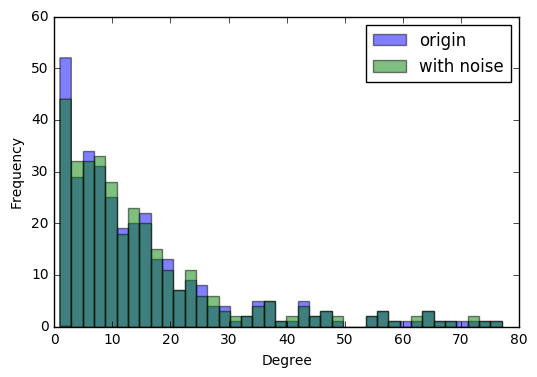

NodeBetweennessCentrality


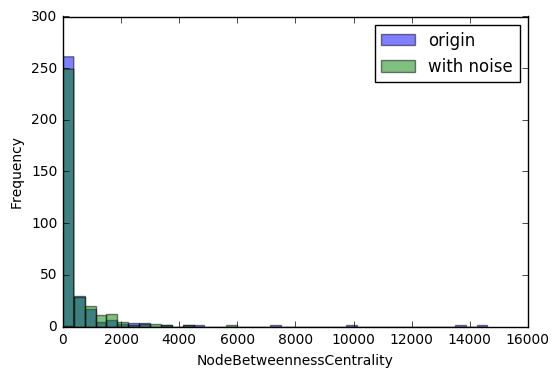

FarnessCentrality


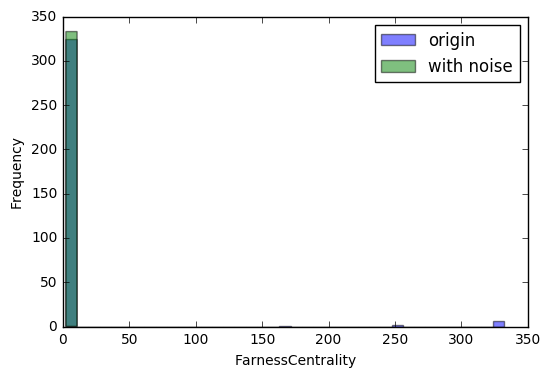

PageRank


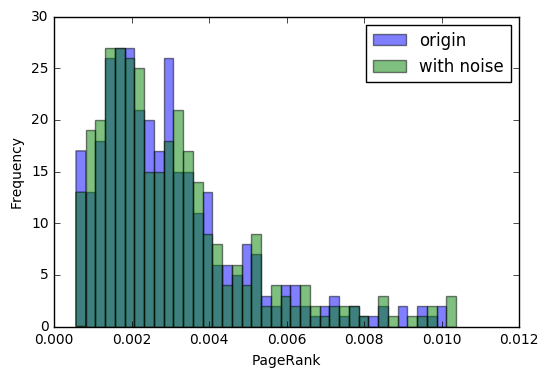

NodeEccentricity


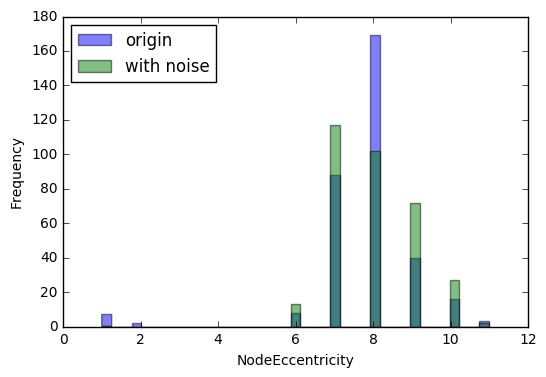

EgonetDegree


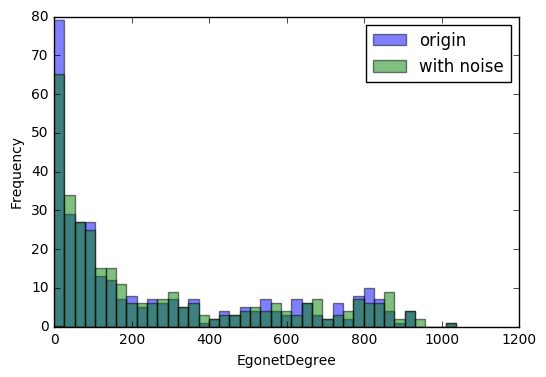

AvgNeighborDeg


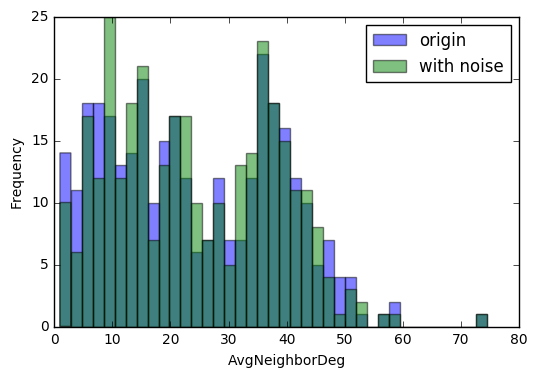

EgonetConnectivity


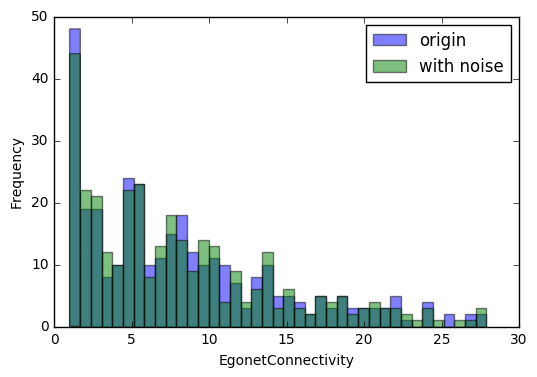

In [3]:
# plot attributes distributin against noise
import matplotlib.pyplot as plt

attributes = ['Degree', 'NodeBetweennessCentrality', 'FarnessCentrality', 'PageRank', 'NodeEccentricity'
              , 'EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
plt.clf()
for attr in attributes:
    print attr
    plt.figure()
    bins = np.linspace(min(min(attributesA[attr]), min(attributesB[attr])), max(max(attributesA[attr]), max(attributesB[attr])), 40)
    plt.hist(attributesA[attr], bins, alpha=0.5, label='origin')
    plt.hist(attributesB[attr], bins, alpha=0.5, label='with noise')
    plt.xlabel(attr)
    plt.ylabel('Frequency')
    plt.legend(loc='best')
    plt.show()

In [4]:
from attr_utils import *
from lsh_utils import *

attributes = ['Degree', 'NodeBetweennessCentrality', 'FarnessCentrality', 'PageRank', 'NodeEccentricity'
             , 'EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']

for i in range(len(attributes)):
    print 'KL Divergence of %s between normal and noised' %(attributes[i]), KL_sim(attributesB[attributes[i]], attributesB_noise[attributes[i]])


KL Divergence of Degree between normal and noised 0.0207009992408
KL Divergence of NodeBetweennessCentrality between normal and noised 0.212696067401
KL Divergence of FarnessCentrality between normal and noised 0.00785634754433
KL Divergence of PageRank between normal and noised 0.0353334188704
KL Divergence of NodeEccentricity between normal and noised 0.135581229269
KL Divergence of EgonetDegree between normal and noised 0.0293203223916
KL Divergence of AvgNeighborDeg between normal and noised 0.0240285130153
KL Divergence of EgonetConnectivity between normal and noised 0.0104059964279


In [5]:
from lsh_utils import *

combineAB = selectAndCombine(attributesA, attributesB_noise)

bandDeg = ['Degree','PageRank','NodeBetweennessCentrality']
bucketDeg = generateCosineBuckets(selectAndCombine(attributesA, attributesB_noise, bandDeg), 30)
with open('metadata/buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())

bandEdge = ['EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
bucketEdge = generateCosineBuckets(selectAndCombine(attributesA, attributesB_noise, bandEdge), 40)
with open('metadata/buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateCosineBuckets(selectAndCombine(attributesA, attributesB_noise, bandAll), 20)
print len(bucketAll.items())

buckets = [bucketDeg, bucketEdge]

48
70
78


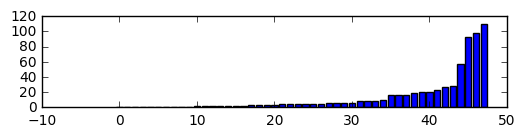

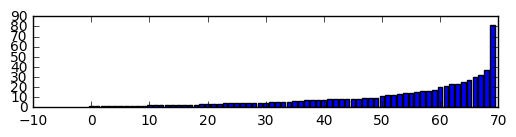

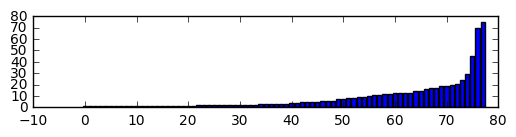

In [6]:
#plot cosine bucket distribution
pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges')
            
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(313)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

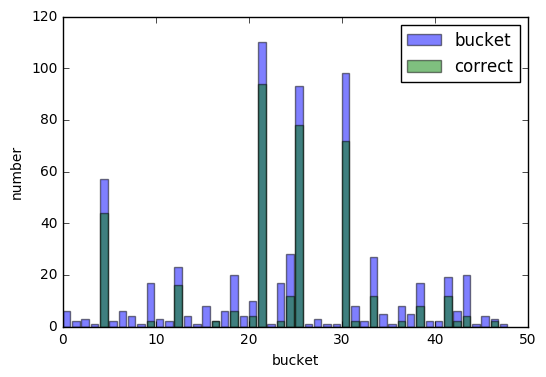

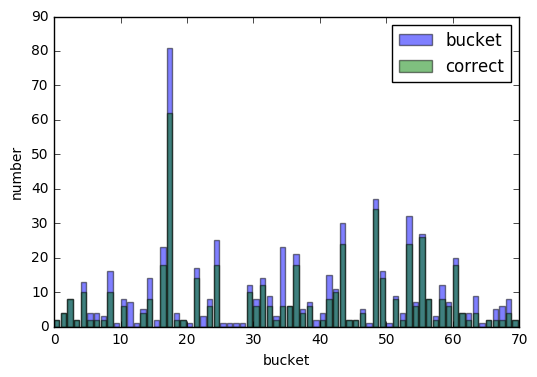

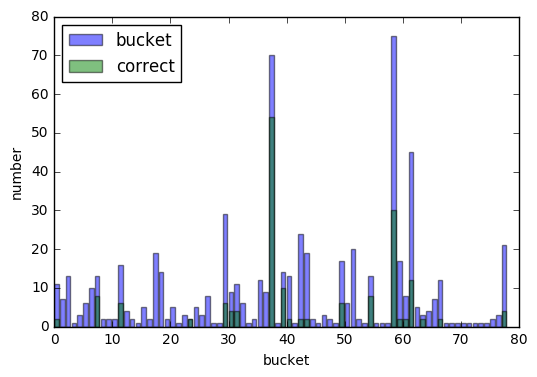

In [7]:
# plot cosine bucket correctness
def plotCorrectness(d, n):
    correct = {}
    for v, k in d.items():
        cnt = 0
        for i in k:
            if (i < n):
                if (i + n in k):
                    cnt += 2
            else:
                break
        correct[v] = cnt
    plt.clf
    plt.figure()
    plt.bar(range(len(d)), [len(v) for k,v in d.items()], alpha=0.5, label='bucket', color='blue')
    plt.bar(range(len(correct)), [correct[k] for k,v in d.items()], alpha=0.5, label='correct', color='green')
    plt.xlabel('bucket')
    plt.ylabel('number')
    plt.legend(loc='best')
    plt.show()
    
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [28]:
matching_matrix = computeMatchingMat(attributesA, attributesB_noise, pair_count_dict, 'Cosine')
sim_matrix = computeWholeSimMat(attributesA, attributesB_noise, 'Cosine')
Ranking = Rank(matching_matrix, P)
Best_ranking = Rank(sim_matrix, P)

In [29]:
print "matching score: %f" %(sum(Ranking)/len(Ranking))
print "matching score upper bound: %f" %(sum(Best_ranking)/len(Best_ranking))
score = hungarianMatch(sim_matrix, P)
upper_bound_score = sum(score)/float(len(score))
print "hungarian matching score upper bound: %f" %(upper_bound_score)
print "percentage of pairs computed: %f" %(len(pair_count_dict)
                                           /float(matching_matrix.shape[0]*matching_matrix.shape[1]/2-matching_matrix.shape[0]))

show_list = [0, 10, 20, 50]
top_k = 5
for i in show_list:
    print "cos sim top %d for node %d:" %(top_k, attributesA['Id'][i])
    print attributesB['Id'][sim_matrix[i].argsort()[-top_k:]].values
    print "matching top %d for node %d:"%(top_k, attributesA['Id'][i])
    print attributesB['Id'][matching_matrix[i].argsort()[-top_k:]].values


matching score: 0.594416
matching score upper bound: 0.415473
hungarian matching score upper bound: 0.378378
percentage of pairs computed: 0.091778
cos sim top 5 for node 1:
[170  51 122   1  77]
matching top 5 for node 1:
[148 188  81 151   1]
cos sim top 5 for node 11:
[201 227 212  11 254]
matching top 5 for node 11:
[133 180 102 201  11]
cos sim top 5 for node 21:
[316  21 325 111 266]
matching top 5 for node 21:
[ 72 221 153 161 300]
cos sim top 5 for node 51:
[  5  76 113   7 211]
matching top 5 for node 51:
[170 122  25  51 113]


In [11]:
bandDeg = ['Degree','PageRank','NodeBetweennessCentrality']
bucketDeg = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandDeg), 1)
bucketDeg2 = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandDeg), 1)
with open('metadata/euc-buckets-band-1', 'w') as f:
    for k, v in bucketDeg.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketDeg.items())
print len(bucketDeg2.items())

bandEdge = ['EgonetDegree', 'AvgNeighborDeg', 'EgonetConnectivity']
bucketEdge = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandEdge), 1)
bucketEdge2 = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandEdge), 1)
with open('metadata/euc-buckets-band-2', 'w') as f:
    for k, v in bucketEdge.items():
        f.write(str(k) + str(v) + '\n')
print len(bucketEdge.items())
print len(bucketEdge2.items())

bandAll = ['Degree','PageRank', 'NodeBetweennessCentrality','FarnessCentrality', 'NodeEccentricity']
bucketAll = generateEuclideanBuckets(selectAndCombine(attributesA, attributesB_noise, bandAll), 2)
print len(bucketAll.items())
buckets = [bucketDeg, bucketEdge]
buckets_long = [bucketDeg, bucketDeg2, bucketEdge, bucketEdge2]


pair_count_dict = combineBucketsBySum(buckets, combineAB, 'metadata/A.edges') 
pair_count_dict_long = combineBucketsBySum(buckets_long, combineAB, 'metadata/A.edges') 

73
105
62
46
50


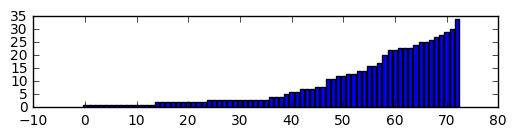

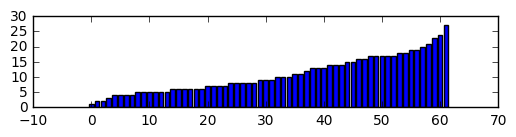

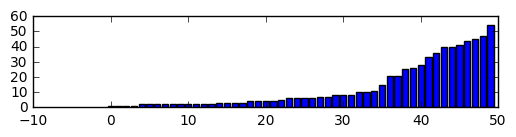

In [12]:
import matplotlib.pyplot as plt
plt.subplot(311)
plotBucketDistribution(bucketDeg)
plt.subplot(312)
plotBucketDistribution(bucketEdge)
plt.subplot(313)
plotBucketDistribution(bucketAll)
plt.show()

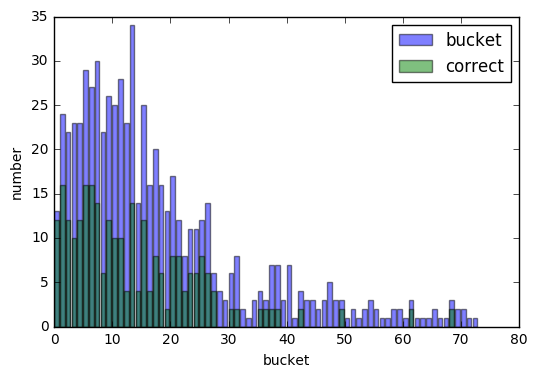

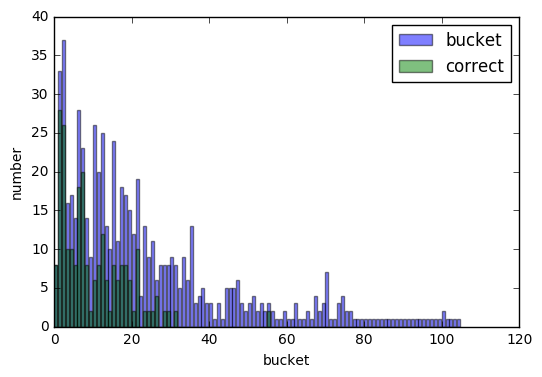

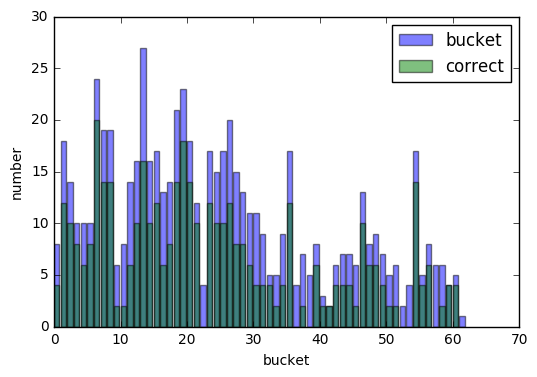

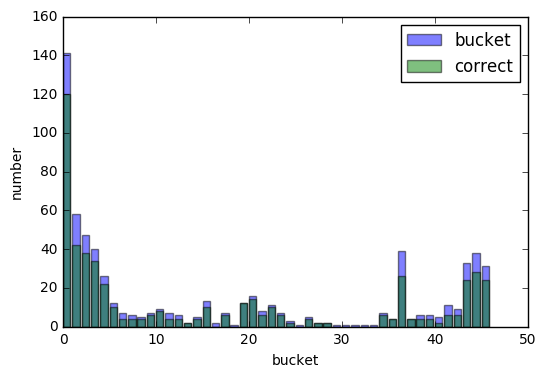

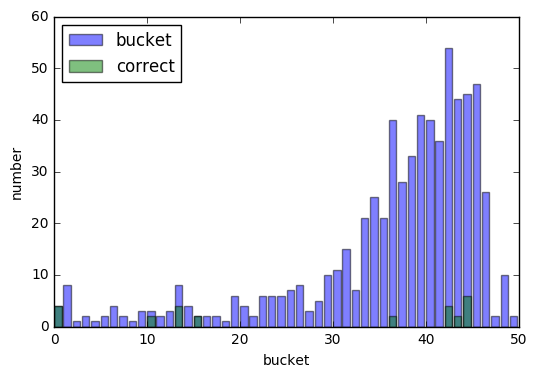

In [13]:
plotCorrectness(bucketDeg, attributesA.shape[0])
plotCorrectness(bucketDeg2, attributesA.shape[0])
plotCorrectness(bucketEdge, attributesA.shape[0])
plotCorrectness(bucketEdge2, attributesA.shape[0])
plotCorrectness(bucketAll, attributesA.shape[0])

In [30]:
matching_matrix = computeMatchingMat(attributesA, attributesB, pair_count_dict, 'Euclidean')
matching_matrix_long = computeMatchingMat(attributesA, attributesB, pair_count_dict_long, 'Euclidean')
sim_matrix = computeWholeSimMat(attributesA, attributesB, 'Euclidean')
Ranking = Rank(matching_matrix, P)
Ranking_long = Rank(matching_matrix_long, P)
Best_ranking = Rank(sim_matrix, P)

print "matching score: %f" %(sum(Ranking)/len(Ranking))
print "matching score: %f" %(sum(Ranking_long)/len(Ranking_long))
print "matching score upper bound: %f" %(sum(Best_ranking)/len(Best_ranking))
score = hungarianMatch(sim_matrix, P)
upper_bound_score = sum(score)/float(len(score))
print "hungarian matching score upper bound: %f" %(upper_bound_score)
print "percentage of pairs computed: %f" %(len(pair_count_dict)
                                           /float(matching_matrix.shape[0]*matching_matrix.shape[1]/2-matching_matrix.shape[0]))
print "percentage of pairs computed with more buckets: %f" %(len(pair_count_dict_long)
                                           /float(matching_matrix_long.shape[0]*matching_matrix_long.shape[1]/2-matching_matrix_long.shape[0]))


matching score: 0.705117
matching score: 0.756364
matching score upper bound: 1.000000
hungarian matching score upper bound: 1.000000
percentage of pairs computed: 0.091778
percentage of pairs computed with more buckets: 0.257825


hungarian matching score upper bound: 1.000000
